In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

In [3]:
movies_df=pd.read_csv('ml-latest-small/movies.csv',usecols=['movieId','title'],dtype={'movieId':'int32'})
ratings_df=pd.read_csv('ml-latest-small/ratings.csv',usecols=['userId','movieId','rating'],
                      dtype={'movieId':'int32','userId':'int32','rating':'float32'})

In [6]:
movies_df.head()

movieId                               title
0        1                    Toy Story (1995)
1        2                      Jumanji (1995)
2        3             Grumpier Old Men (1995)
3        4            Waiting to Exhale (1995)
4        5  Father of the Bride Part II (1995)

In [7]:
ratings_df.head()

userId  movieId  rating
0       1        1     4.0
1       1        3     4.0
2       1        6     4.0
3       1       47     5.0
4       1       50     5.0

In [8]:
movies_df=movies_df.merge(ratings_df,on='movieId')
movies_df.head()

movieId             title  userId  rating
0        1  Toy Story (1995)       1     4.0
1        1  Toy Story (1995)       5     4.0
2        1  Toy Story (1995)       7     4.5
3        1  Toy Story (1995)      15     2.5
4        1  Toy Story (1995)      17     4.5

In [12]:
combine_movie_rating=movies_df.dropna(axis=0,subset=['title'])
Rating_count=combine_movie_rating.groupby(by='title')['rating'].count().reset_index().rename(columns={'rating':'Total_Ratings'})
Rating_count.head()

title  Total_Ratings
0                               '71 (2014)              1
1  'Hellboy': The Seeds of Creation (2004)              1
2                   'Round Midnight (1986)              2
3                      'Salem's Lot (2004)              1
4                'Til There Was You (1997)              2

In [13]:
movies_df=combine_movie_rating.merge(Rating_count,left_on='title',right_on='title',how='left')
movies_df.head()

movieId             title  userId  rating  Total_Ratings
0        1  Toy Story (1995)       1     4.0            215
1        1  Toy Story (1995)       5     4.0            215
2        1  Toy Story (1995)       7     4.5            215
3        1  Toy Story (1995)      15     2.5            215
4        1  Toy Story (1995)      17     4.5            215

In [14]:
movies_df['Total_Ratings'].describe()

count    100836.000000
mean         58.758777
std          61.965384
min           1.000000
25%          13.000000
50%          39.000000
75%          84.000000
max         329.000000
Name: Total_Ratings, dtype: float64

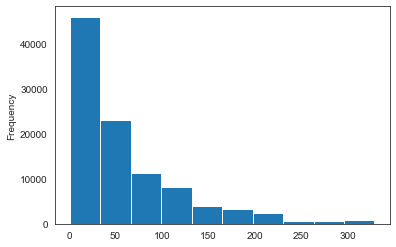

In [15]:
movies_df['Total_Ratings'].plot(kind='hist')

In [17]:
popularity_threshold=50
rating_popular=movies_df[movies_df['Total_Ratings']>=popularity_threshold]
rating_popular.head()

movieId             title  userId  rating  Total_Ratings
0        1  Toy Story (1995)       1     4.0            215
1        1  Toy Story (1995)       5     4.0            215
2        1  Toy Story (1995)       7     4.5            215
3        1  Toy Story (1995)      15     2.5            215
4        1  Toy Story (1995)      17     4.5            215

In [18]:
rating_popular.shape

(41362, 5)

In [19]:
#creating a pivot matrix
movies_features_df=rating_popular.pivot_table(index='title',columns='userId',values='rating').fillna(0)
movies_features_df.head()

userId                             1    2    3    4    5    6    7    8    \
title                                                                       
10 Things I Hate About You (1999)  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
12 Angry Men (1957)                0.0  0.0  0.0  5.0  0.0  0.0  0.0  0.0   
2001: A Space Odyssey (1968)       0.0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   
28 Days Later (2002)               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
300 (2007)                         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

userId                             9    10   ...  601  602  603  604  605  \
title                                        ...                            
10 Things I Hate About You (1999)  0.0  0.0  ...  0.0  0.0  3.0  0.0  5.0   
12 Angry Men (1957)                0.0  0.0  ...  5.0  0.0  0.0  0.0  0.0   
2001: A Space Odyssey (1968)       0.0  0.0  ...  0.0  0.0  5.0  0.0  0.0   
28 Days Later (2002)               0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
300 (2007)                         0.0  3.0  ...  0.0  0.0  0.0  0.0  3.0   

userId                             606  607  608  609  610  
title                                                       
10 Things I Hate About You (1999)  0.0  0.0  0.0  0.0  0.0  
12 Angry Men (1957)                0.0  0.0  0.0  0.0  0.0  
2001: A Space Odyssey (1968)       5.0  0.0  3.0  0.0  4.5  
28 Days Later (2002)               0.0  0.0  3.5  0.0  5.0  
300 (2007)                         0.0  0.0  5.0  0.0  4.0  

[5 rows x 606 columns]

In [20]:
from scipy.sparse import csr_matrix
movies_features_df_matrix=csr_matrix(movies_features_df.values)

from sklearn.neighbors import NearestNeighbors
model_knn=NearestNeighbors(metric='cosine',algorithm='brute')
model_knn.fit(movies_features_df_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [21]:
movies_features_df.shape

(450, 606)

In [27]:
query_index=np.random.choice(movies_features_df.shape[0])
print(query_index)
distances,indices=model_knn.kneighbors(movies_features_df.iloc[query_index,:].values.reshape(1,-1),n_neighbors=6)

60


In [29]:
for i in range(len(distances.flatten())):
    if i==0:
        print("Recommendations for {0}:\n".format(movies_features_df.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}'.format(i,movies_features_df.index[indices.flatten()[i]],
                                                     distances.flatten()[i]))

Recommendations for Blair Witch Project, The (1999):

1: Scream (1996), with distance of 0.5023043155670166
2: Mars Attacks! (1996), with distance of 0.5586181879043579
3: Sixth Sense, The (1999), with distance of 0.5649528503417969
4: There's Something About Mary (1998), with distance of 0.5743944644927979
5: Raising Arizona (1987), with distance of 0.5776981115341187
